In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02):
  drips = []
  for i in range(len(data) - min_window):
    # ข้าม drip ก่อนหน้า
    if drips and i < drips[-1]['end_index']:
      continue
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+min_window].min()
    drip_pct = (low_price - close_price) / close_price
    
    # ตรวจสอบเงื่อนไขการลดลงมากกว่า 3%
    if drip_pct <= threshold:
      end_index = i + min_window - 1
      duration = end_index - i + 1
      
      for j in range(i, i+max_window):
        high = data['high'].iloc[j]
        low = data['low'].iloc[j]
        open_price = data['open'].iloc[j]
        close = data['close'].iloc[j]
        
        # คำนวณ high-to-low % และตรวจสอบว่า open-to-close เป็นบวก
        high_to_low_pct = (high - low) / low
        if (close > open_price) and (high_to_low_pct > increase_threshold):
          end_index = j
          duration = end_index - i + 1
          drip_pct = (low_price - close_price) / close_price
          break
      
      if duration >= min_window and duration <= max_window:
        drips.append({
          'start_time': data.index[i],
          'close_price': close_price,
          'low_price': low_price,
          'drip_pct': drip_pct * 100,  # แปลงเป็น %
          'end_index': end_index,
          'duration': duration
        })
        
  
  return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data = data["2021-01-01":]
drips = detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02)

Summary of Indicators at Drip Low (3% in 6-48 Hours):

RSI:
Count: 464.00
Mean: 34.42
Std: 10.13
Min: 5.56
Max: 72.32
Median: 34.42
25th Percentile: 27.21
75th Percentile: 41.26

MACD:
Count: 464.00
Mean: -284.10
Std: 438.70
Min: -2319.58
Max: 1357.45
Median: -230.15
25th Percentile: -486.44
75th Percentile: -43.14

MACD_SIGNAL:
Count: 464.00
Mean: -148.48
Std: 415.06
Min: -1990.71
Max: 1466.32
Median: -125.13
25th Percentile: -358.04
75th Percentile: 67.43

MACD_HIST:
Count: 464.00
Mean: -135.62
Std: 139.49
Min: -947.87
Max: 332.25
Median: -115.90
25th Percentile: -204.27
75th Percentile: -46.96

VOLUME:
Count: 464.00
Mean: 8604.10
Std: 8977.91
Min: 1427.71
Max: 58740.90
Median: 5716.51
25th Percentile: 3735.44
75th Percentile: 9595.08


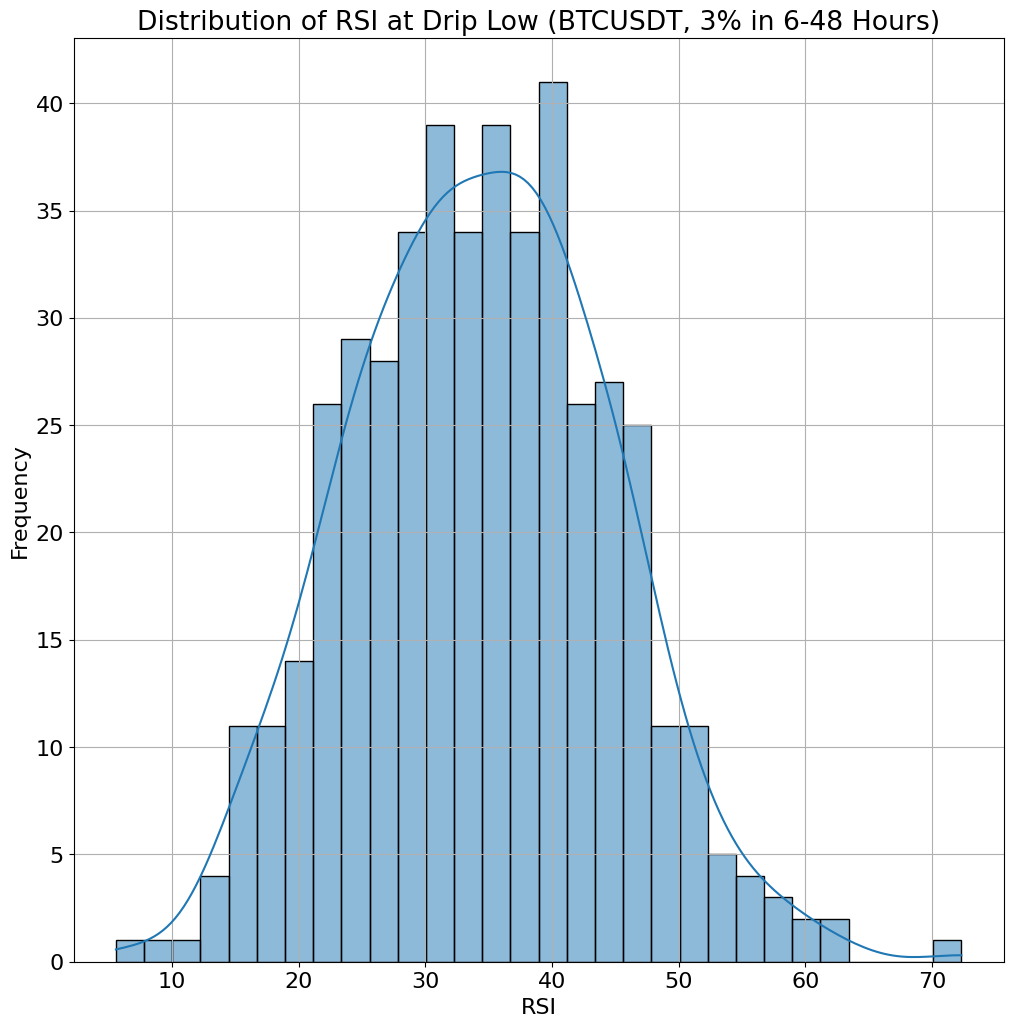

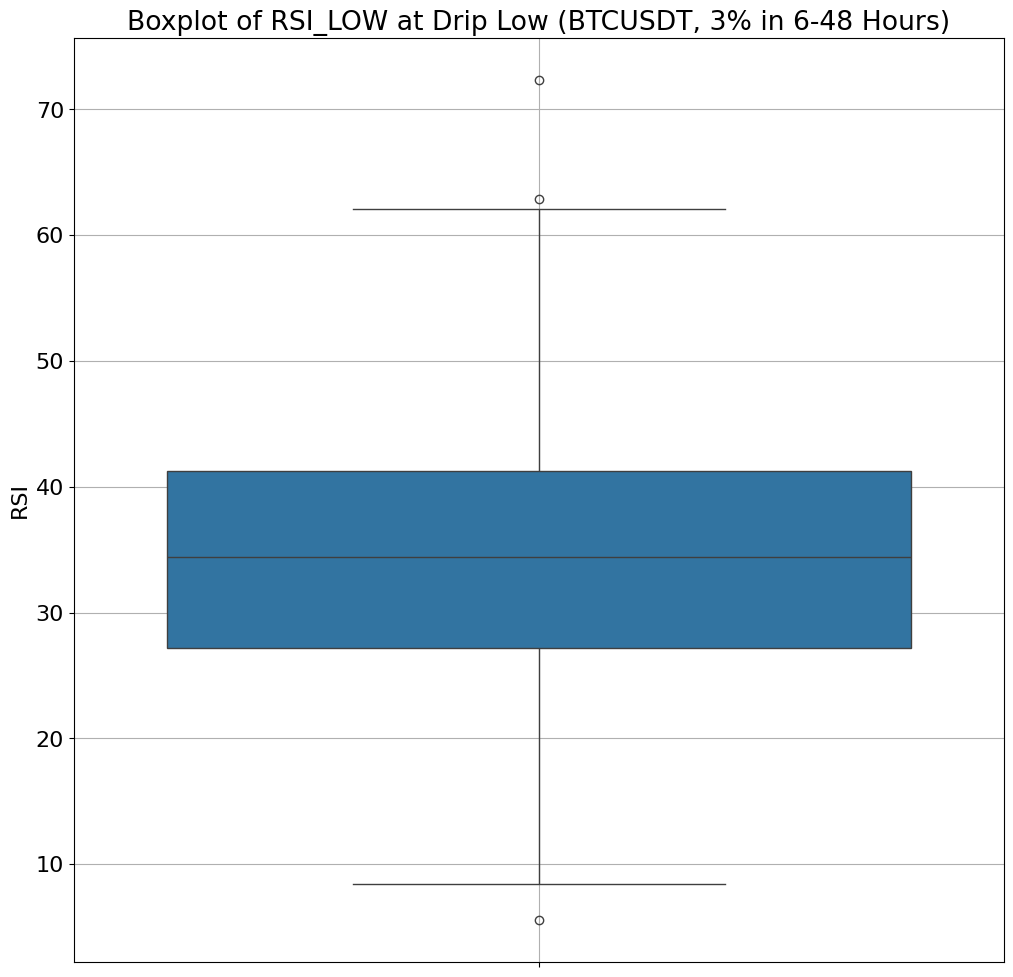

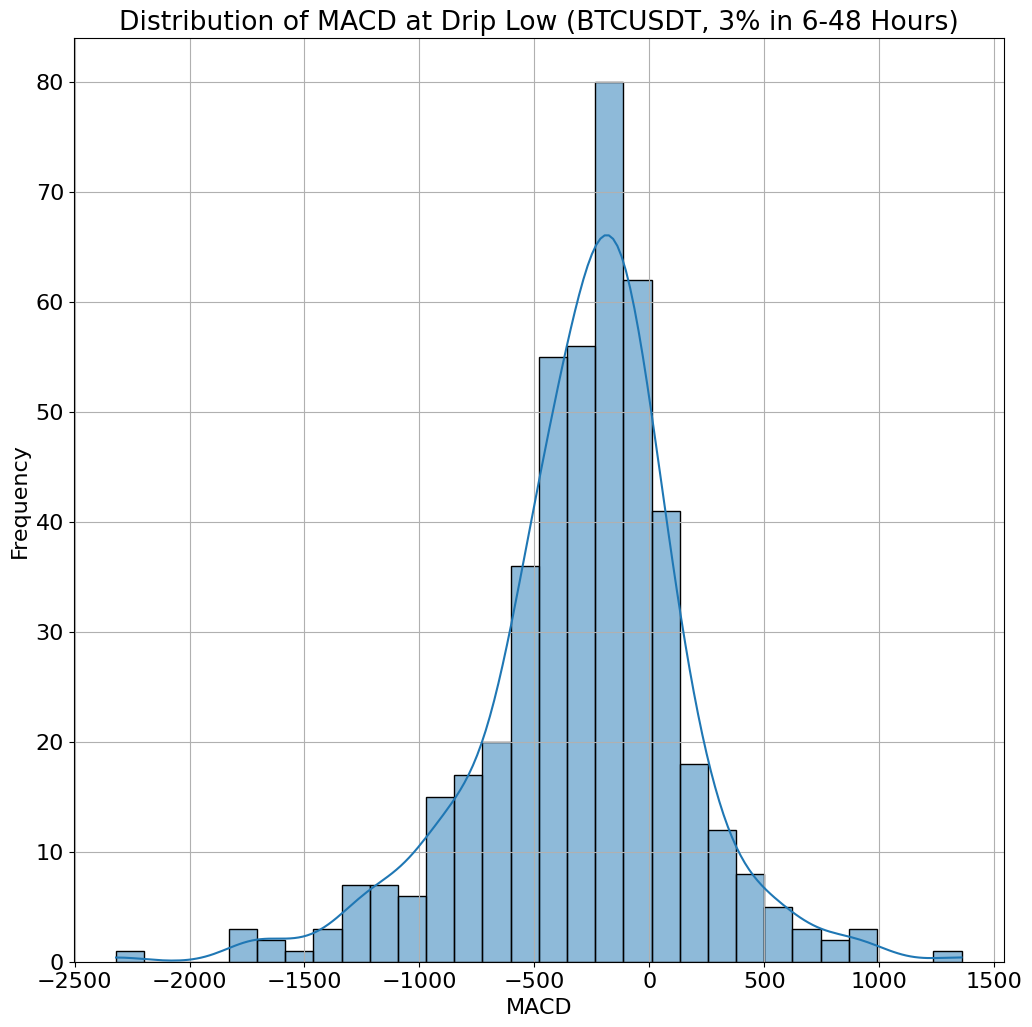

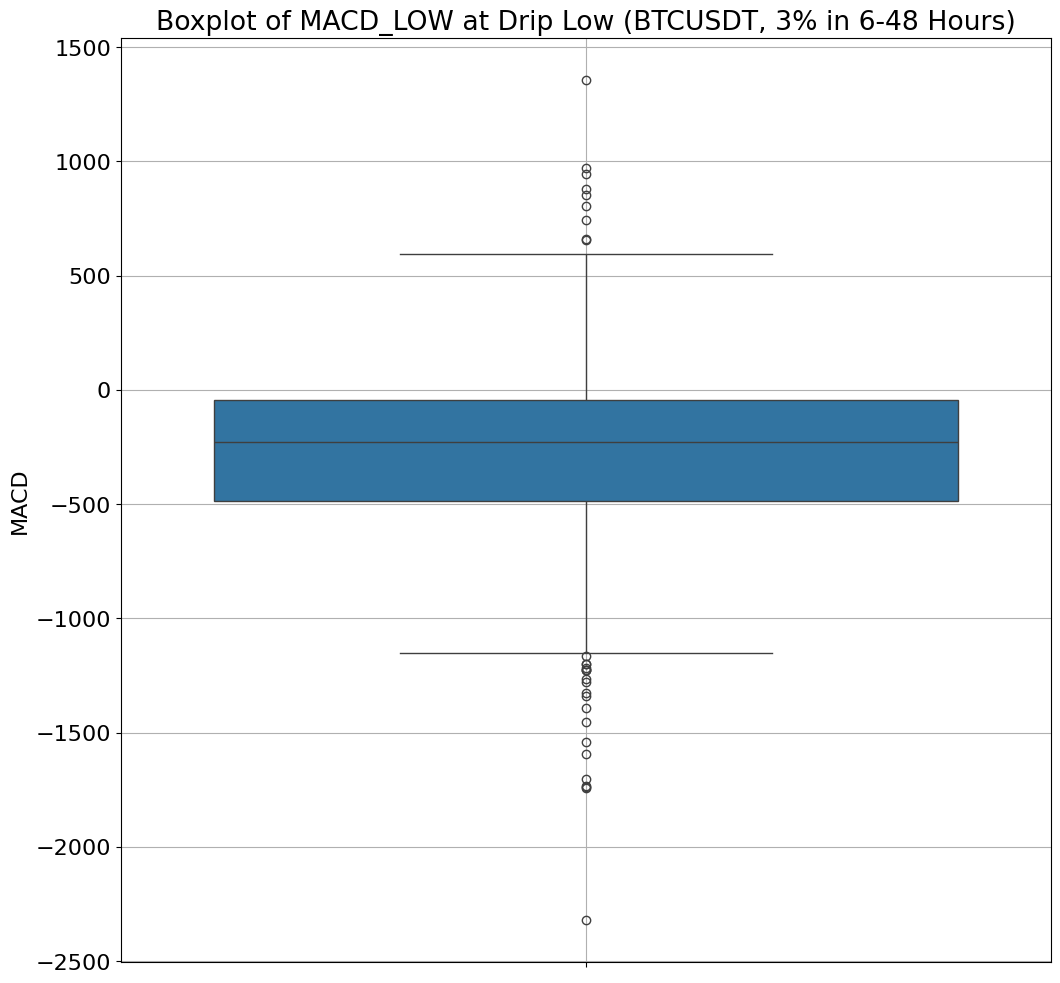

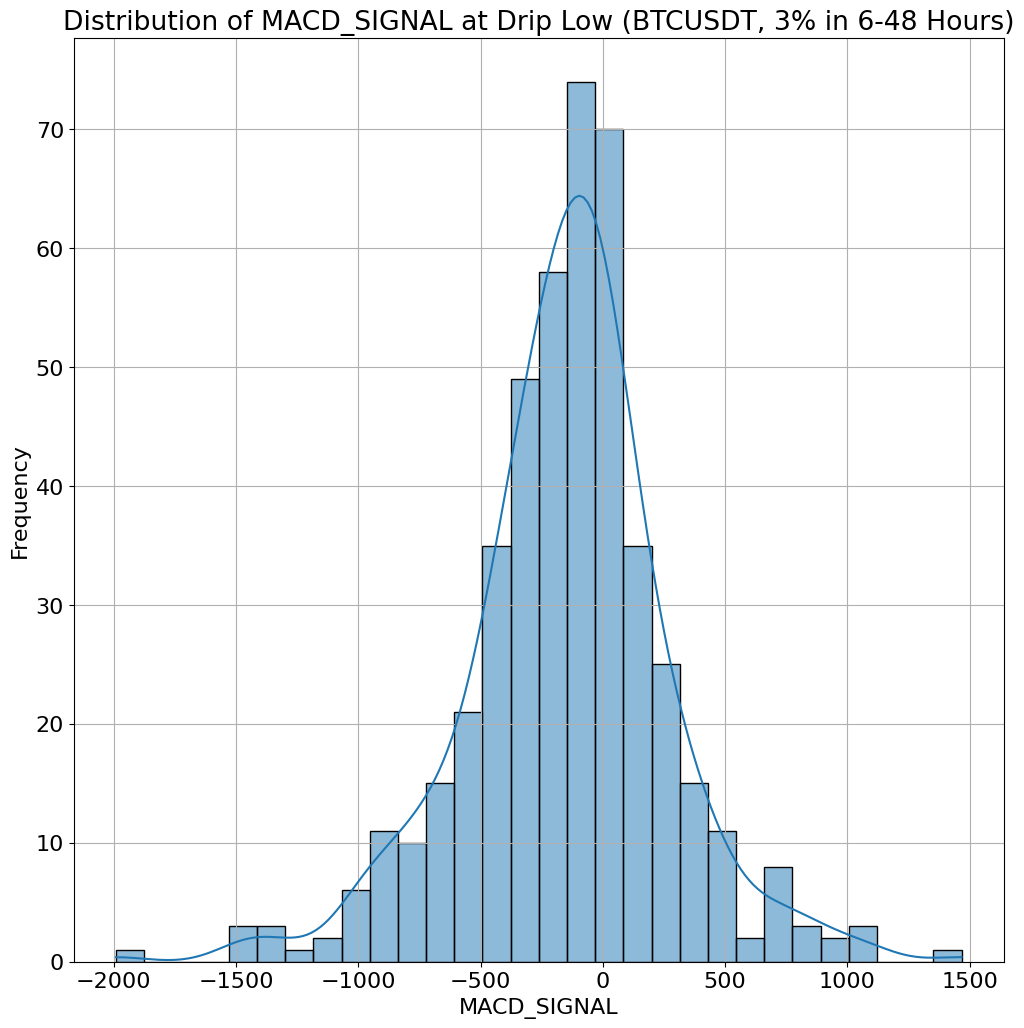

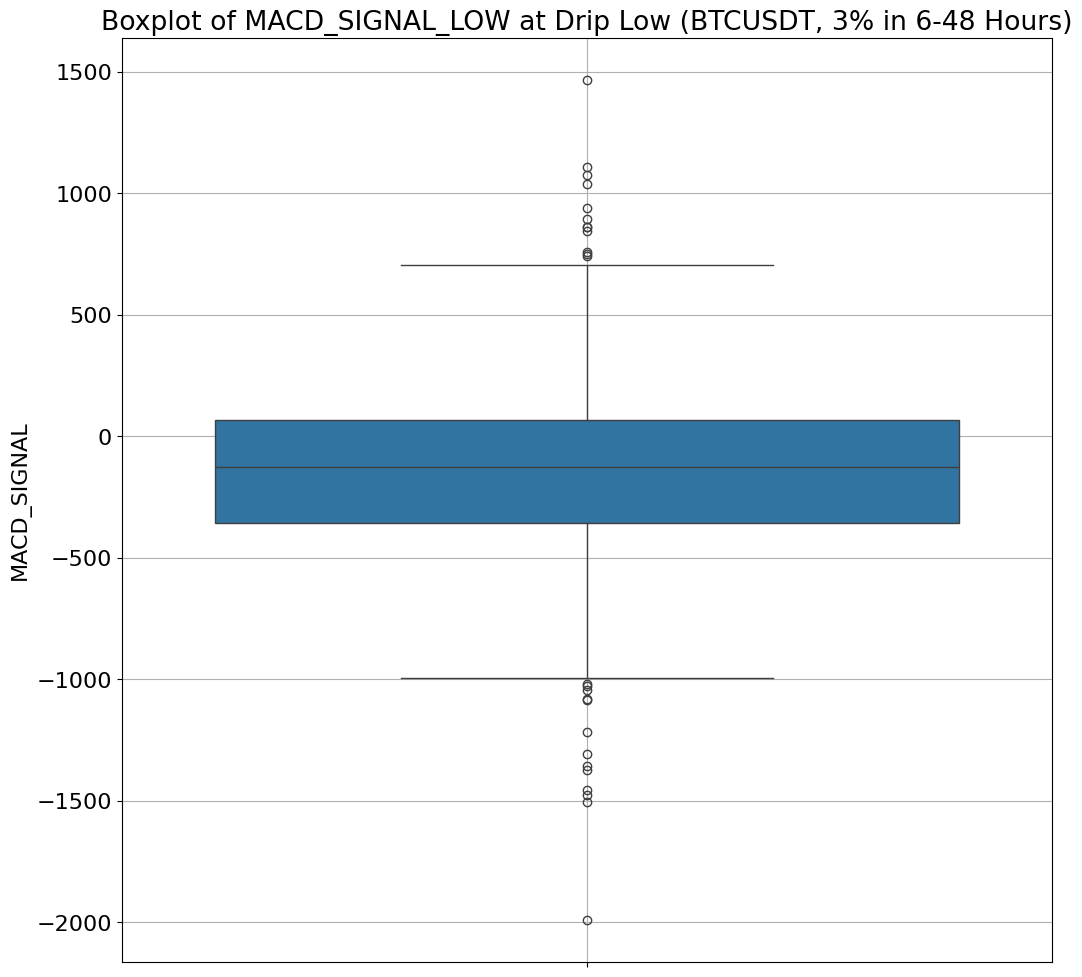

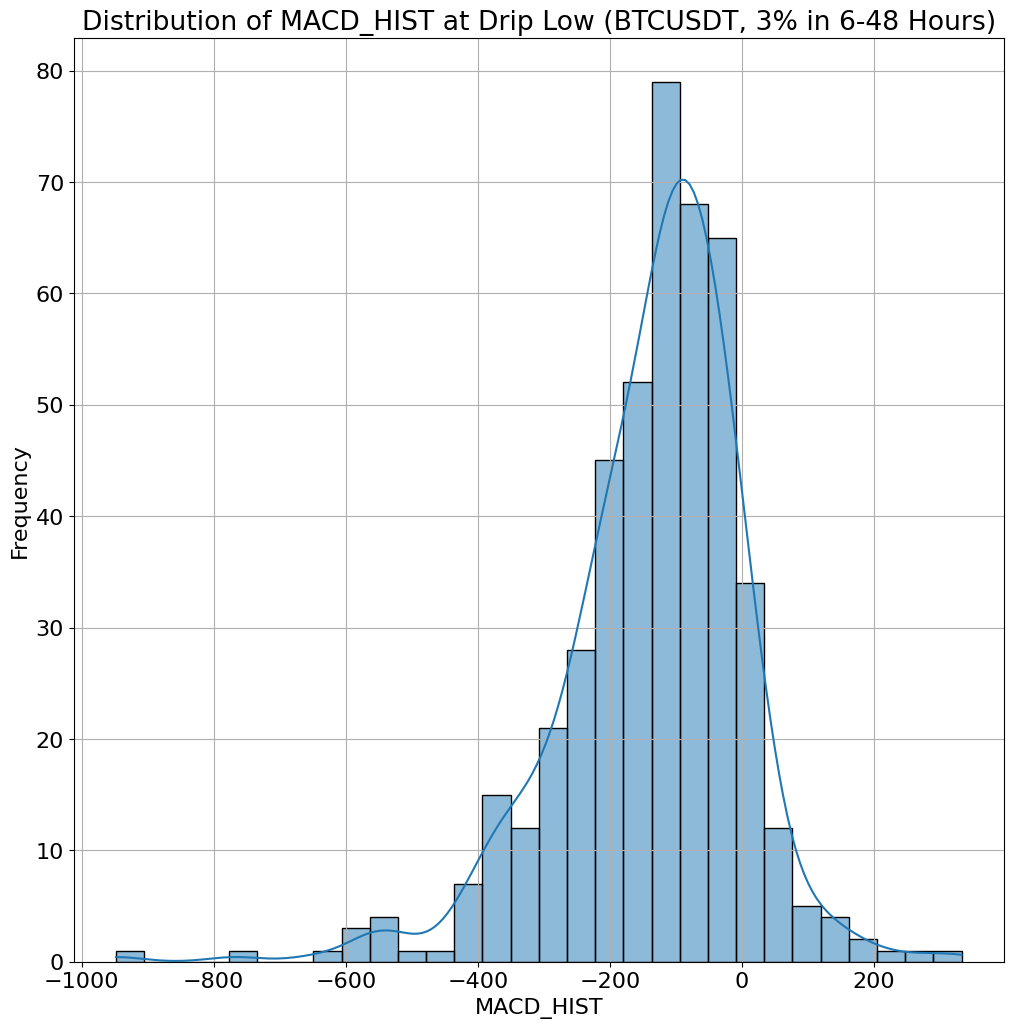

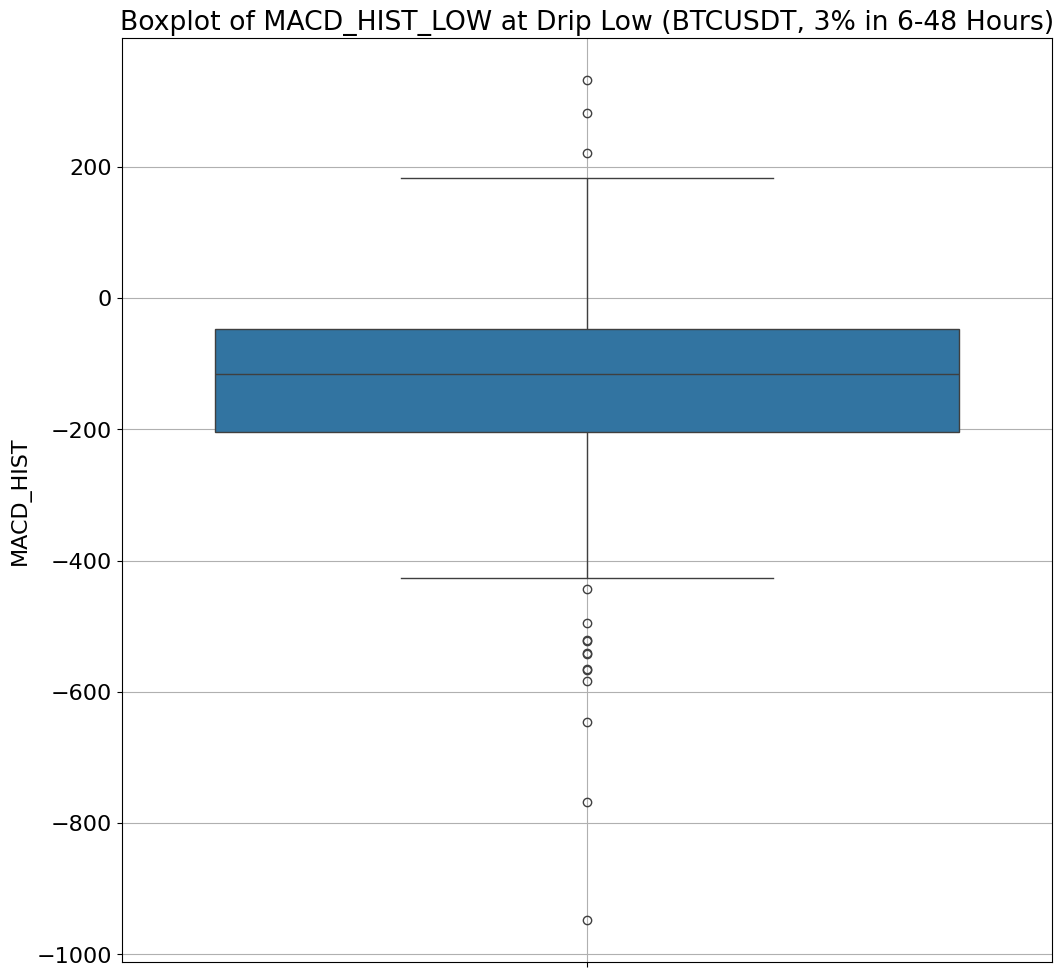

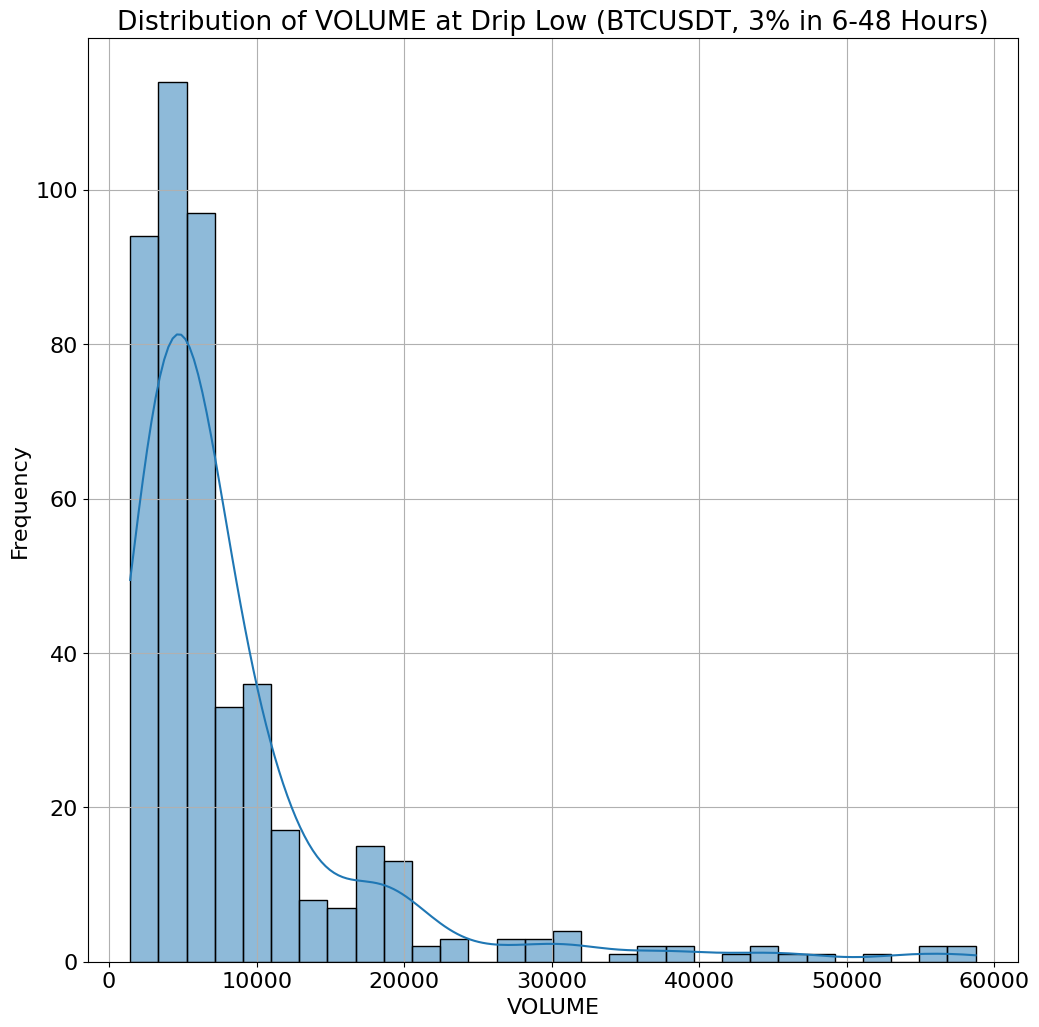

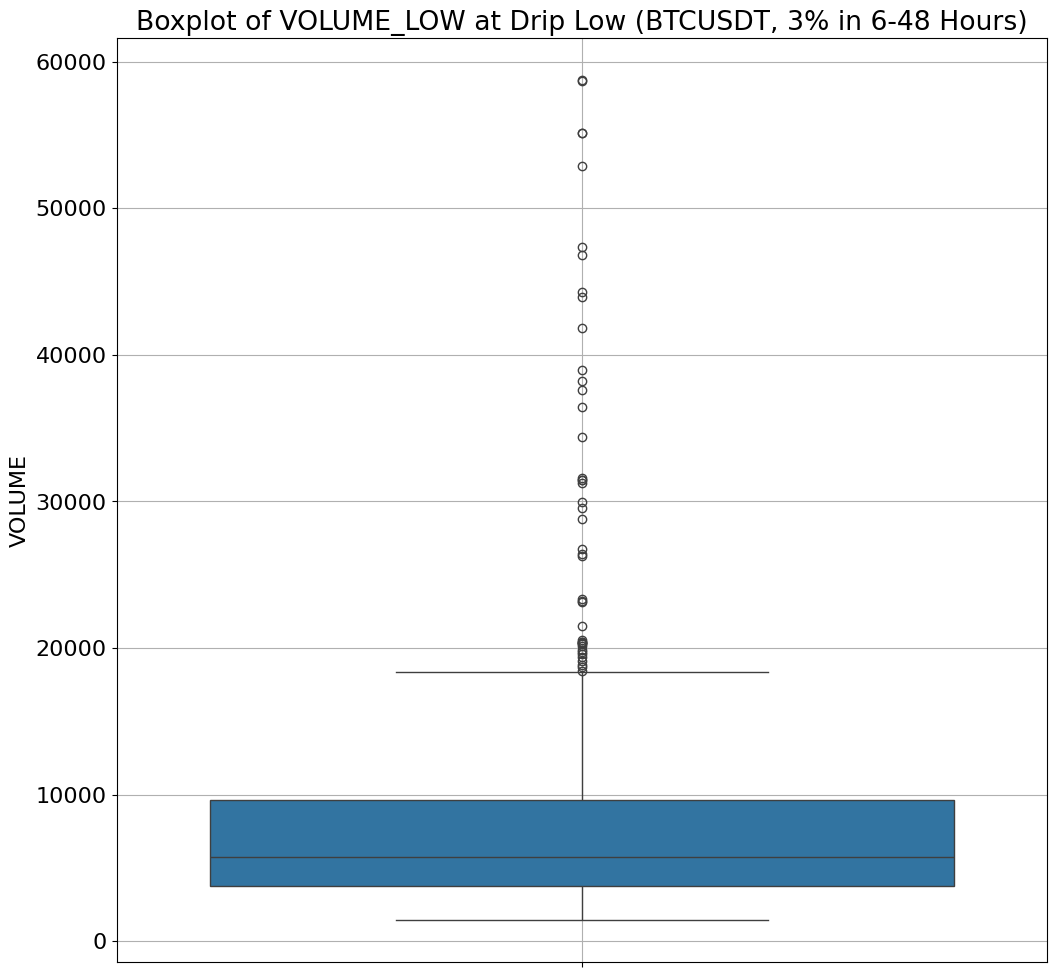


Shapiro-Wilk Test for RSI:
stat=0.9968, p-value=0.5018
The distribution is normal (p >= 0.05)

Shapiro-Wilk Test for MACD:
stat=0.9600, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for MACD_SIGNAL:
stat=0.9711, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for MACD_HIST:
stat=0.9357, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for VOLUME:
stat=0.6474, p-value=0.0000
The distribution is not normal (p < 0.05)


In [4]:
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close', 'volume']] if 'volume' in data.columns else data[['open', 'high', 'low', 'close']]

# คำนวณตัวชี้วัด RSI และ MACD
data['rsi'] = ta.rsi(data['close'], length=14)
macd = ta.macd(data['close'], fast=12, slow=26, signal=9)
data['macd'] = macd['MACD_12_26_9']
data['macd_signal'] = macd['MACDs_12_26_9']
data['macd_hist'] = macd['MACDh_12_26_9']

# ฟังก์ชันหาเวลาของจุดต่ำสุด (low_price) ในแต่ละ Drip
def get_low_time(row, data, window=48):
    start_idx = data.index.get_loc(row['start_time'])
    end_idx = min(start_idx + row['duration'], len(data) - 1)
    low_price_idx = data['low'].iloc[start_idx:end_idx].idxmin()
    return low_price_idx

# เพิ่มคอลัมน์สำหรับเวลาของจุดต่ำสุด
drips['low_time'] = drips.apply(lambda row: get_low_time(row, data), axis=1)

# เพิ่มคอลัมน์สำหรับ RSI, MACD, และ Volume ณ จุดต่ำสุดของ Drip
drips['rsi_low'] = drips['low_time'].apply(lambda x: data.loc[x, 'rsi'] if x in data.index else np.nan)
drips['macd_low'] = drips['low_time'].apply(lambda x: data.loc[x, 'macd'] if x in data.index else np.nan)
drips['macd_signal_low'] = drips['low_time'].apply(lambda x: data.loc[x, 'macd_signal'] if x in data.index else np.nan)
drips['macd_hist_low'] = drips['low_time'].apply(lambda x: data.loc[x, 'macd_hist'] if x in data.index else np.nan)
if 'volume' in data.columns:
    drips['volume_low'] = drips['low_time'].apply(lambda x: data.loc[x, 'volume'] if x in data.index else np.nan)

# 1. สรุปสถิติของ RSI, MACD, และ Volume ณ จุดต่ำสุด
print("Summary of Indicators at Drip Low (3% in 6-48 Hours):")
indicators = ['rsi_low', 'macd_low', 'macd_signal_low', 'macd_hist_low']
if 'volume' in data.columns:
    indicators.append('volume_low')

for indicator in indicators:
    print(f"\n{indicator.replace('_low', '').upper()}:")
    my_stats = {
        'Count': drips[indicator].count(),
        'Mean': drips[indicator].mean(),
        'Std': drips[indicator].std(),
        'Min': drips[indicator].min(),
        'Max': drips[indicator].max(),
        'Median': drips[indicator].median(),
        '25th Percentile': drips[indicator].quantile(0.25),
        '75th Percentile': drips[indicator].quantile(0.75)
    }
    for key, value in my_stats.items():
        print(f"{key}: {value:.2f}")

# 2. สร้าง Histogram และ Boxplot สำหรับแต่ละตัวชี้วัด
for indicator in indicators:
    # Histogram
    plt.figure(figsize=(12, 12))
    sns.histplot(drips[indicator].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {indicator.replace("_low", "").upper()} at Drip Low (BTCUSDT, 3% in 6-48 Hours)')
    plt.xlabel(indicator.replace('_low', '').upper())
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Boxplot
    plt.figure(figsize=(12, 12))
    sns.boxplot(y=drips[indicator].dropna())
    plt.title(f'Boxplot of {indicator.replace("_ low", "").upper()} at Drip Low (BTCUSDT, 3% in 6-48 Hours)')
    plt.ylabel(indicator.replace('_low', '').upper())
    plt.grid(True)
    plt.show()

# 3. ทดสอบความปกติของการแจกแจง
for indicator in indicators:
    stat, p_value = stats.shapiro(drips[indicator].dropna().sample(min(5000, len(drips[indicator].dropna()))))
    print(f"\nShapiro-Wilk Test for {indicator.replace('_low', '').upper()}:")
    print(f"stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("The distribution is not normal (p < 0.05)")
    else:
        print("The distribution is normal (p >= 0.05)")